# Airline Price Regression

By: Mohamed Fawzy

In [1]:
# Import needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import Normalizer
from category_encoders import BinaryEncoder
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.exceptions import NotFittedError

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.compose import ColumnTransformer

from sklearn.metrics import get_scorer_names, make_scorer, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import joblib

In [2]:
# Set the display option to show all columns
pd.set_option('display.max_columns', None)

# Set the figure size for all plots
sns.set(rc={'figure.figsize':(14, 10)}, font_scale=1.2)

In [3]:
# Read the dataset
df = pd.read_excel('Airline Price.xlsx')

### Describing Data:

In [4]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [6]:
for col in df.columns:
    print(f'Unique values for ({col}): {len(df[col].unique())}')

Unique values for (Airline): 12
Unique values for (Date_of_Journey): 44
Unique values for (Source): 5
Unique values for (Destination): 6
Unique values for (Route): 129
Unique values for (Dep_Time): 222
Unique values for (Arrival_Time): 1343
Unique values for (Duration): 368
Unique values for (Total_Stops): 6
Unique values for (Additional_Info): 10
Unique values for (Price): 1870


In [7]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


## Data Exploration:

In [8]:
df['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [9]:
df['Date_of_Journey'].unique()

array(['24/03/2019', '1/05/2019', '9/06/2019', '12/05/2019', '01/03/2019',
       '24/06/2019', '12/03/2019', '27/05/2019', '1/06/2019',
       '18/04/2019', '9/05/2019', '24/04/2019', '3/03/2019', '15/04/2019',
       '12/06/2019', '6/03/2019', '21/03/2019', '3/04/2019', '6/05/2019',
       '15/05/2019', '18/06/2019', '15/06/2019', '6/04/2019',
       '18/05/2019', '27/06/2019', '21/05/2019', '06/03/2019',
       '3/06/2019', '15/03/2019', '3/05/2019', '9/03/2019', '6/06/2019',
       '24/05/2019', '09/03/2019', '1/04/2019', '21/04/2019',
       '21/06/2019', '27/03/2019', '18/03/2019', '12/04/2019',
       '9/04/2019', '1/03/2019', '03/03/2019', '27/04/2019'], dtype=object)

In [10]:
df['Source'].value_counts()

Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [11]:
df['Destination'].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [12]:
df['Route'].value_counts()

DEL → BOM → COK          2376
BLR → DEL                1552
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
                         ... 
CCU → VTZ → BLR             1
CCU → IXZ → MAA → BLR       1
BOM → COK → MAA → HYD       1
BOM → CCU → HYD             1
BOM → BBI → HYD             1
Name: Route, Length: 128, dtype: int64

In [13]:
df['Dep_Time'].value_counts()

18:55    233
17:00    227
07:05    205
10:00    203
07:10    202
        ... 
16:25      1
01:35      1
21:35      1
04:15      1
03:00      1
Name: Dep_Time, Length: 222, dtype: int64

In [14]:
df['Arrival_Time'].value_counts()

19:00           423
21:00           360
19:15           333
16:10           154
12:35           122
               ... 
00:25 02 Jun      1
08:55 13 Mar      1
11:05 19 May      1
12:30 22 May      1
21:20 13 Mar      1
Name: Arrival_Time, Length: 1343, dtype: int64

In [15]:
df['Duration'].value_counts()

2h 50m     550
1h 30m     386
2h 45m     337
2h 55m     337
2h 35m     329
          ... 
31h 30m      1
30h 25m      1
42h 5m       1
4h 10m       1
47h 40m      1
Name: Duration, Length: 368, dtype: int64

In [16]:
df['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [17]:
df['Additional_Info'].value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [18]:
df['Price'].value_counts()

10262    258
10844    212
7229     162
4804     160
4823     131
        ... 
14153      1
8488       1
7826       1
6315       1
12648      1
Name: Price, Length: 1870, dtype: int64

## Data Preprocessing:

- Check for duplicate rows

In [19]:
# Check for duplicates
df.duplicated().sum()

220

In [20]:
# Drop duplicates
df.drop_duplicates(inplace=True)

- Check for rows with missing values

In [21]:
# Check for missing values
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [22]:
# Remove the missing values
df.dropna(inplace=True)

- Handle values in `Date_of_Journey`

In [23]:
# Convert the date of journey to datetime
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])

- Reset Index

In [24]:
# Reset the index of the dataframe rows
df.reset_index(drop=True, inplace=True)

- Handle values in `Duration`

In [25]:
# define a function to convert the duration into minutes
def duration(x):
    x = x.split()
    if len(x) == 2:
        return int(x[0][:-1]) * 60 + int(x[1][:-1])
    else:
        if 'h' in x[0]:
            return int(x[0][:-1]) * 60
        elif 'm' in x[0]:
            return int(x[0][:-1])
        else:
            return np.nan

# Apply the function
df['Duration'] = df['Duration'].apply(duration)

- Handle values in `Dep_Time`, `Arrival_Time`

In [26]:
# define a function to extract the time from Arrival_Time
def arrival_time(x):
    return x.split(' ')[0]

# Apply the function
df['Arrival_Time'] = df['Arrival_Time'].apply(arrival_time)

# Convert the Dep_Time and Arrival_Time to datetime
df['Dep_Time'] = pd.to_datetime(df['Dep_Time'])
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time'])

# Add the duration to the departure time to get the corrected arrival time
df['Arrival_Time'] = df['Dep_Time'] + pd.to_timedelta(df['Duration'], unit='m')

# Convert Dep_Time and Arrival_Time to time
df['Dep_Time'] = df['Dep_Time'].dt.time
df['Arrival_Time'] = df['Arrival_Time'].dt.time

- Handle values in `Total_Stops`

In [27]:
# Define a function to calculate the total stops
def total_stops(x):
    if x == 'non-stop':
        return 0
    else:
        return x.split(' ')[0]

# Apply the function
df['Total_Stops'] = df['Total_Stops'].apply(total_stops)

# Convert Total_Stops to integer
df['Total_Stops'] = df['Total_Stops'].astype('int64')

### Feature Engineering:

- Create `Route_Status`, `F_Route`, `L_Route`, `N_Route` feature

In [28]:
# Define a function to know if the flight is direct or not
def route_status(x):
    if len(x.split(' → ')) == 2:
        return 'Direct'
    else:
        return 'Indirect'

# Apply the function
df['Route_Status'] = df['Route'].apply(route_status)

In [29]:
# Define a function to get the F_Route
def f_route(x):
    return x.split(' → ')[0]

# Apply the function
df['F_Route'] = df['Route'].apply(f_route)

In [30]:
# Define a function to get the L_Route
def l_route(x):
    return x.split(' → ')[-1]

# Apply the function
df['L_Route'] = df['Route'].apply(l_route)

In [31]:
# Define a function to get the number of routes
def n_route(x):
    return len(x.split(' → '))

# Apply the function
df['N_Route'] = df['Route'].apply(n_route)

- Create `Time_Period` feature

In [32]:
# Define a function to get the time period of the day
def time_period(x):
    if x.hour >= 0 and x.hour < 6:
        return 'Night'
    elif x.hour >= 6 and x.hour < 12:
        return 'Morning'
    elif x.hour >= 12 and x.hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

# Apply the function
df['Time_Period'] = df['Dep_Time'].apply(time_period)

- Create `Year`, `Quarter`, `Month`, `Day_of_Week`, `Season` feature

In [33]:
# Create a new column for the year
df['Year'] = df['Date_of_Journey'].dt.year

# Create a new column for the quarter
df['Quarter'] = df['Date_of_Journey'].dt.quarter

# Create a new column for the month
df['Month'] = df['Date_of_Journey'].dt.month_name()

# Create a new column for the day of the week
df['Day_of_Week'] = df['Date_of_Journey'].dt.day_name()

# Create a new column for the season
df['Season'] = df['Month'].apply(lambda x: 'Winter' if x in ['December', 'January', 'February'] else 'Spring' if x in ['March', 'April', 'May'] else 'Summer' if x in ['June', 'July', 'August'] else 'Autumn')

- Arrange columns in dataframe

In [34]:
df = df[['Airline', 'Date_of_Journey', 'Time_Period', 'Source', 'Destination', 'Duration', 'N_Route', 'Total_Stops', 'Route_Status', 'F_Route', 'L_Route', 'Year', 'Season', 'Quarter', 'Month', 'Day_of_Week', 'Route', 'Dep_Time', 'Arrival_Time', 'Additional_Info', 'Price']]

- Drop `Route`, `Dep_Time`, `Arrival_Time`

In [35]:
df.drop(['Route', 'Dep_Time', 'Arrival_Time'], axis=1, inplace=True)

- Display data details and types

In [36]:
df.head()

,Airline,Date_of_Journey,Time_Period,Source,Destination,Duration,N_Route,Total_Stops,Route_Status,F_Route,L_Route,Year,Season,Quarter,Month,Day_of_Week,Additional_Info,Price
0,IndiGo,2019-03-24,Evening,Banglore,New Delhi,170,2,0,Direct,BLR,DEL,2019,Spring,1,March,Sunday,No info,3897
1,Air India,2019-01-05,Night,Kolkata,Banglore,445,4,2,Indirect,CCU,BLR,2019,Winter,1,January,Saturday,No info,7662
2,Jet Airways,2019-09-06,Morning,Delhi,Cochin,1140,4,2,Indirect,DEL,COK,2019,Autumn,3,September,Friday,No info,13882
3,IndiGo,2019-12-05,Evening,Kolkata,Banglore,325,3,1,Indirect,CCU,BLR,2019,Winter,4,December,Thursday,No info,6218
4,IndiGo,2019-01-03,Afternoon,Banglore,New Delhi,285,3,1,Indirect,BLR,DEL,2019,Winter,1,January,Thursday,No info,13302


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10462 entries, 0 to 10461
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10462 non-null  object        
 1   Date_of_Journey  10462 non-null  datetime64[ns]
 2   Time_Period      10462 non-null  object        
 3   Source           10462 non-null  object        
 4   Destination      10462 non-null  object        
 5   Duration         10462 non-null  int64         
 6   N_Route          10462 non-null  int64         
 7   Total_Stops      10462 non-null  int64         
 8   Route_Status     10462 non-null  object        
 9   F_Route          10462 non-null  object        
 10  L_Route          10462 non-null  object        
 11  Year             10462 non-null  int64         
 12  Season           10462 non-null  object        
 13  Quarter          10462 non-null  int64         
 14  Month            10462 non-null  objec

In [38]:
for col in df.columns:
    print(f'Unique values for ({col}): {len(df[col].unique())}')

Unique values for (Airline): 12
Unique values for (Date_of_Journey): 40
Unique values for (Time_Period): 4
Unique values for (Source): 5
Unique values for (Destination): 6
Unique values for (Duration): 368
Unique values for (N_Route): 5
Unique values for (Total_Stops): 5
Unique values for (Route_Status): 2
Unique values for (F_Route): 5
Unique values for (L_Route): 5
Unique values for (Year): 1
Unique values for (Season): 4
Unique values for (Quarter): 4
Unique values for (Month): 7
Unique values for (Day_of_Week): 7
Unique values for (Additional_Info): 10
Unique values for (Price): 1870


In [39]:
df.describe()

,Duration,N_Route,Total_Stops,Year,Quarter,Price
count,10462.000000,10462.000000,10462.000000,10462.0,10462.000000,10462.000000
mean,629.781591,2.802332,0.802332,2019.0,2.003823,9026.790289
std,500.699045,0.660609,0.660609,0.0,0.895338,4624.849541
min,5.000000,2.000000,0.000000,2019.0,1.000000,1759.000000
25%,170.000000,2.000000,0.000000,2019.0,1.000000,5224.000000
50%,505.000000,3.000000,1.000000,2019.0,2.000000,8266.000000
75%,910.000000,3.000000,1.000000,2019.0,2.000000,12344.750000
max,2860.000000,6.000000,4.000000,2019.0,4.000000,79512.000000


### EDA Results:

<Axes: xlabel='Date_of_Journey', ylabel='Price'>

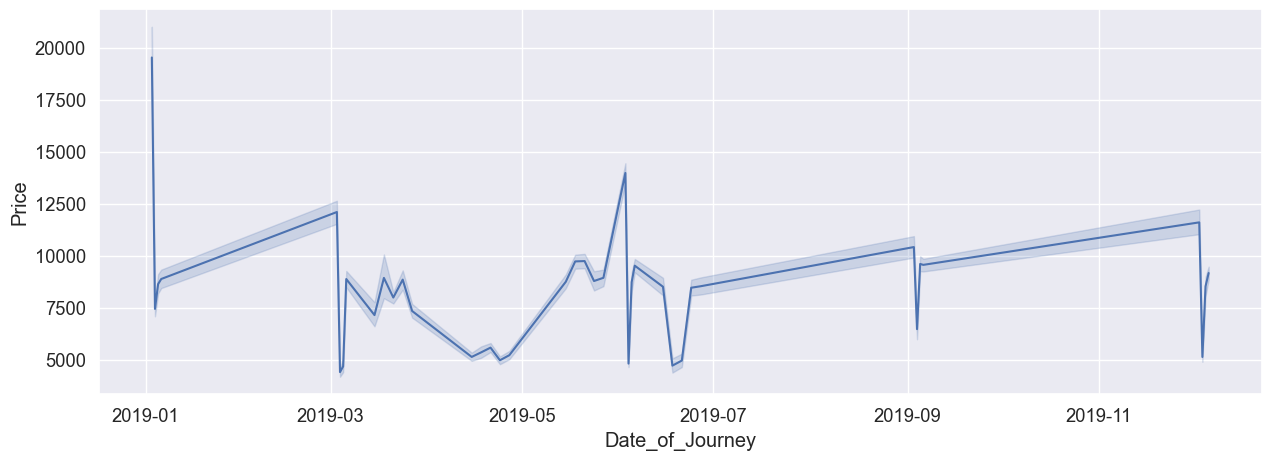

In [40]:
# Show changes in price over the days
plt.figure(figsize=(15, 5))
sns.lineplot(x='Date_of_Journey', y='Price', data=df)

<Axes: xlabel='Airline', ylabel='count'>

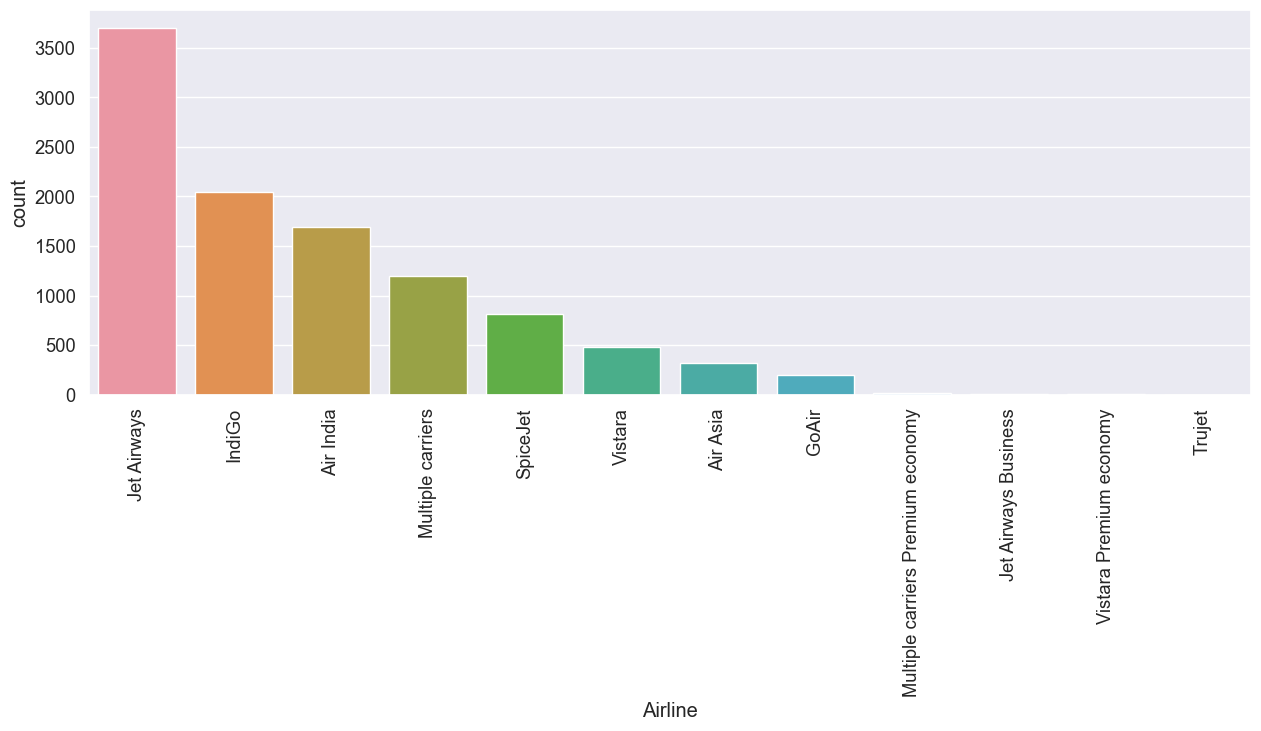

In [41]:
# Show the count of flights for each airline in descending order
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.countplot(x='Airline', data=df, order=df['Airline'].value_counts().index)

<Axes: xlabel='Time_Period', ylabel='count'>

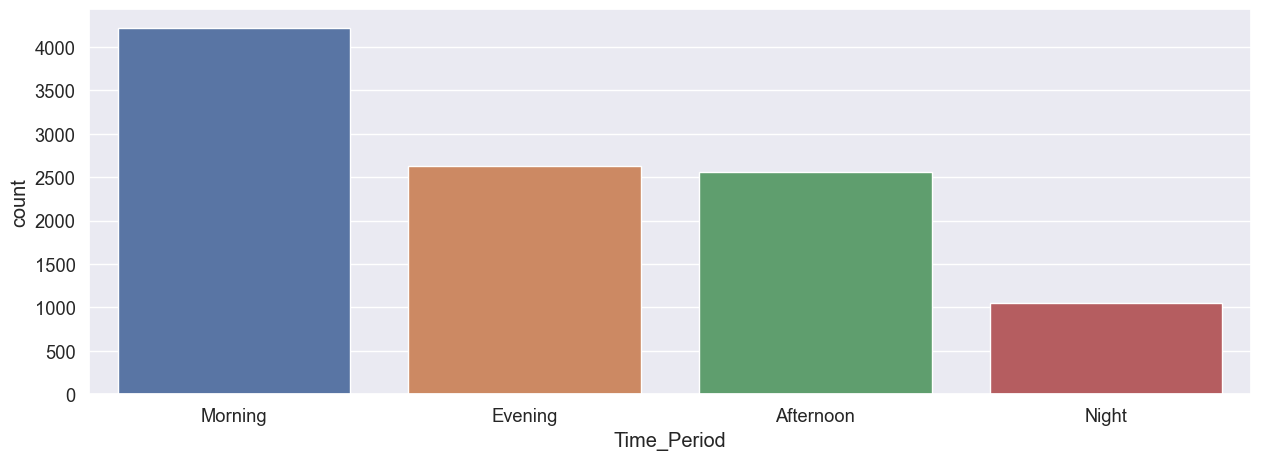

In [42]:
# Show the count of flights for each time period in descending order
plt.figure(figsize=(15, 5))
sns.countplot(x='Time_Period', data=df, order=df['Time_Period'].value_counts().index)

<Axes: xlabel='Source', ylabel='count'>

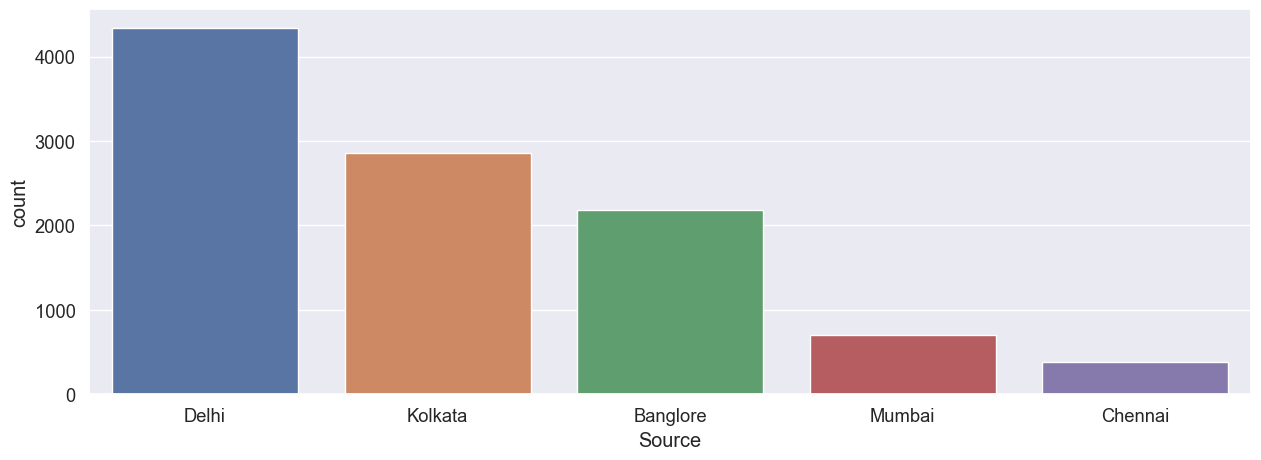

In [43]:
# Show the count of flights for each source in descending order
plt.figure(figsize=(15, 5))
sns.countplot(x='Source', data=df, order=df['Source'].value_counts().index)

<Axes: xlabel='Destination', ylabel='count'>

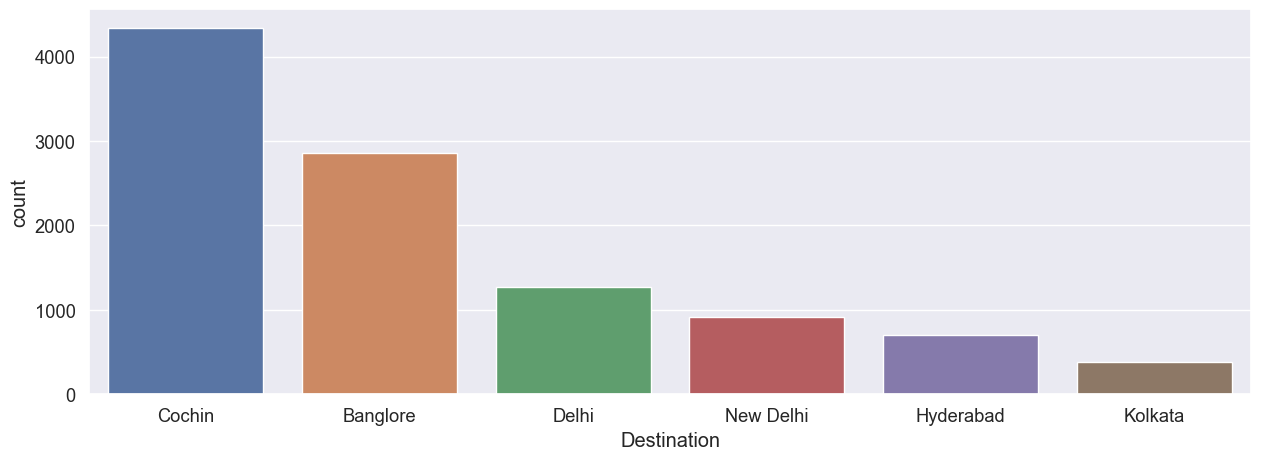

In [44]:
# Show the count of flights for each destination in descending order
plt.figure(figsize=(15, 5))
sns.countplot(x='Destination', data=df, order=df['Destination'].value_counts().index)

<Axes: xlabel='Route_Status', ylabel='count'>

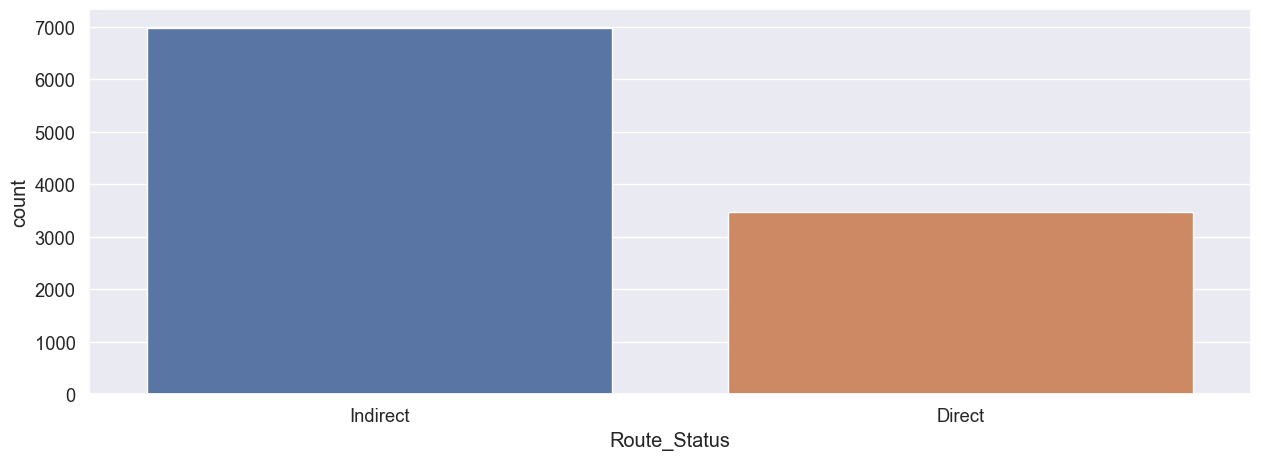

In [45]:
# Show the count of flights for each route status in descending order
plt.figure(figsize=(15, 5))
sns.countplot(x='Route_Status', data=df, order=df['Route_Status'].value_counts().index)

<Axes: xlabel='Duration', ylabel='Price'>

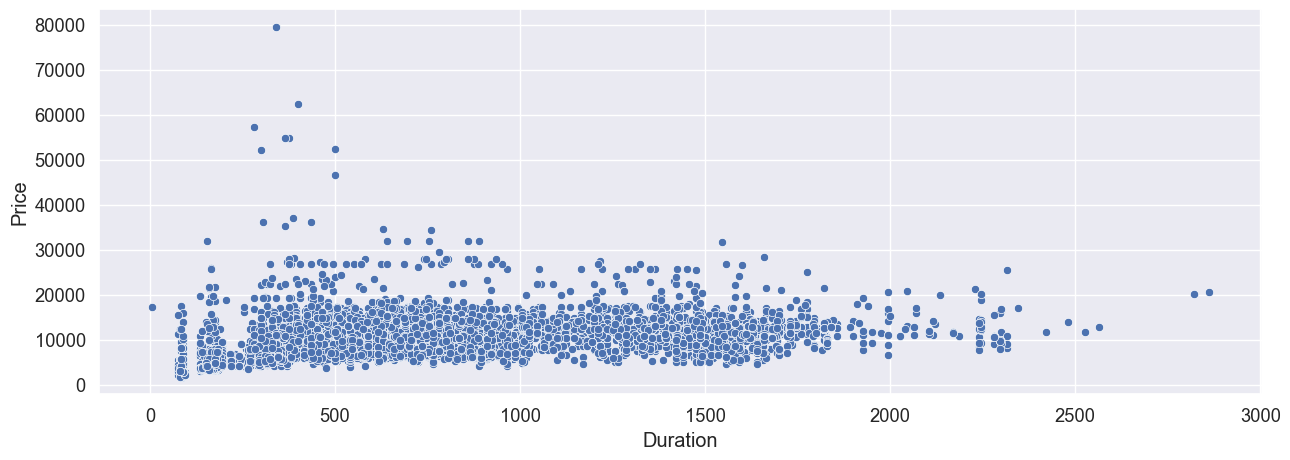

In [46]:
# Show the correlation between duration and price
plt.figure(figsize=(15, 5))
sns.scatterplot(x='Duration', y='Price', data=df)

<Axes: xlabel='Price'>

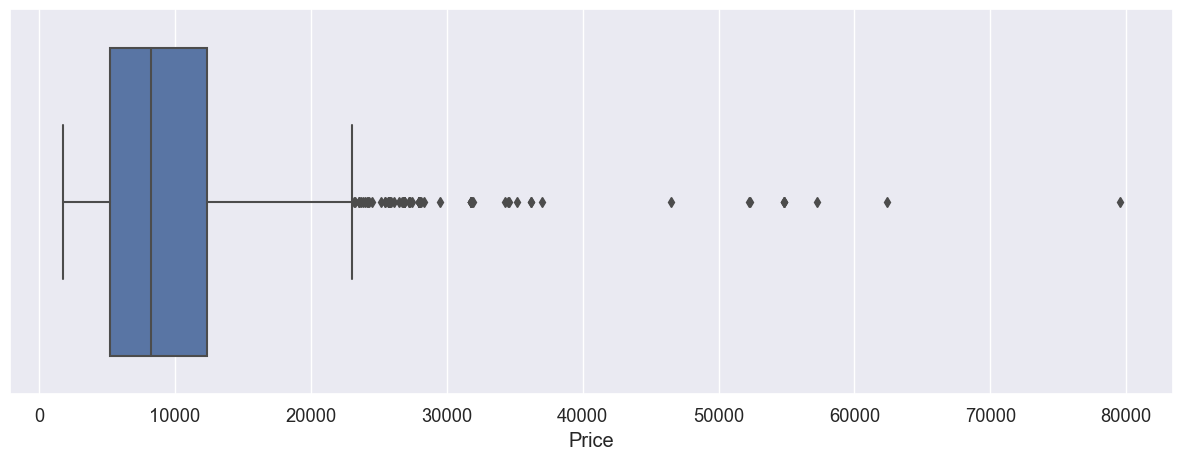

In [47]:
# What is the distribution of flight prices in the dataset? Are there any outliers or extreme values?
plt.figure(figsize=(15, 5))
sns.boxplot(x='Price', data=df)

<Axes: xlabel='Airline', ylabel='Price'>

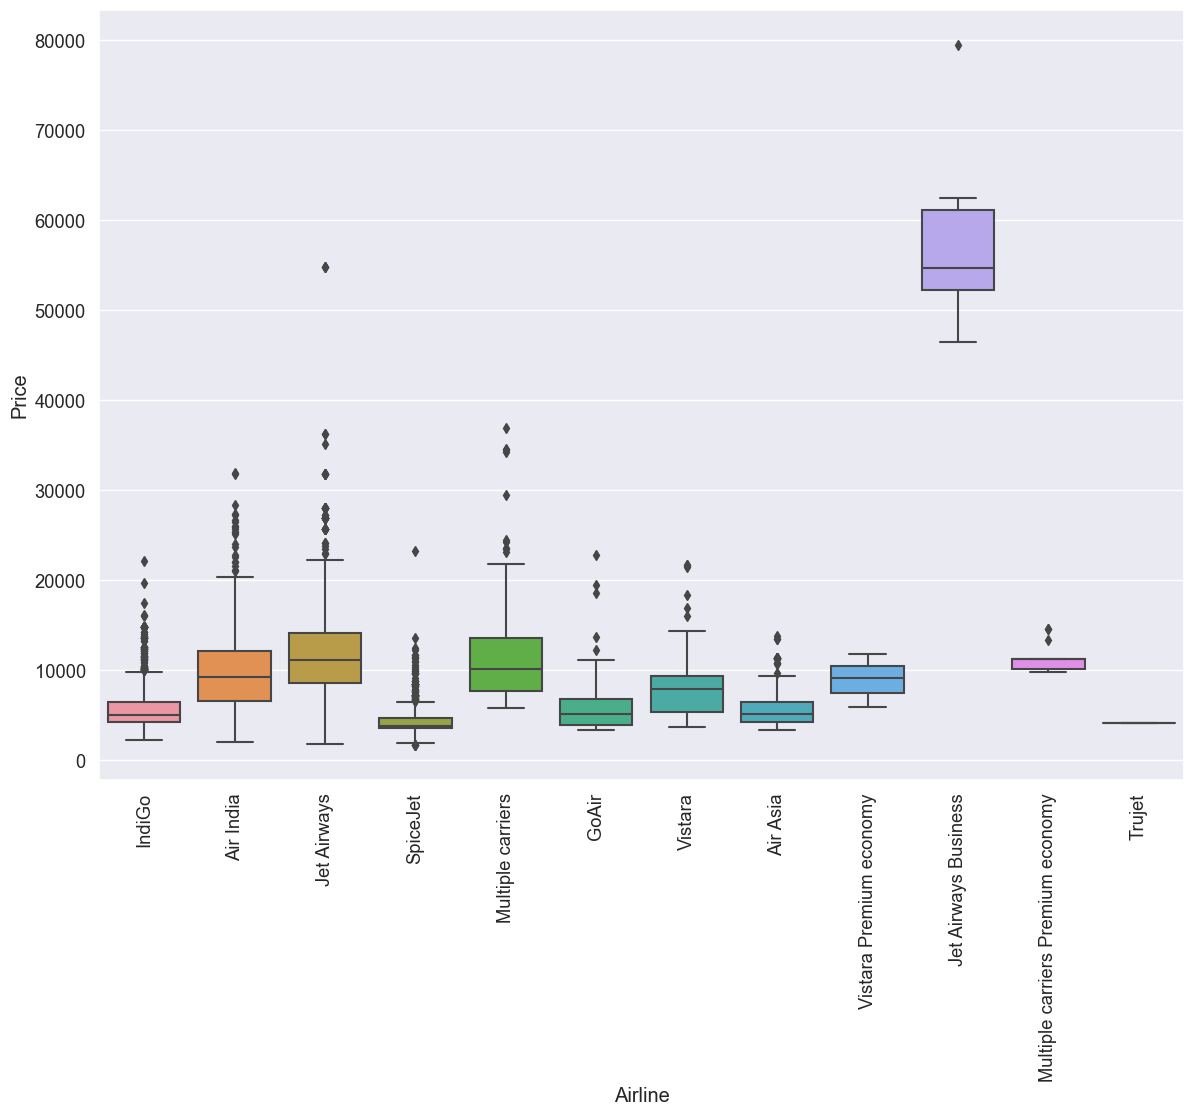

In [48]:
# What is the distribution of flight prices by airline? Are there any outliers or extreme values?
plt.xticks(rotation=90)
sns.boxplot(data=df, x='Airline', y='Price')

<Axes: xlabel='Additional_Info', ylabel='Price'>

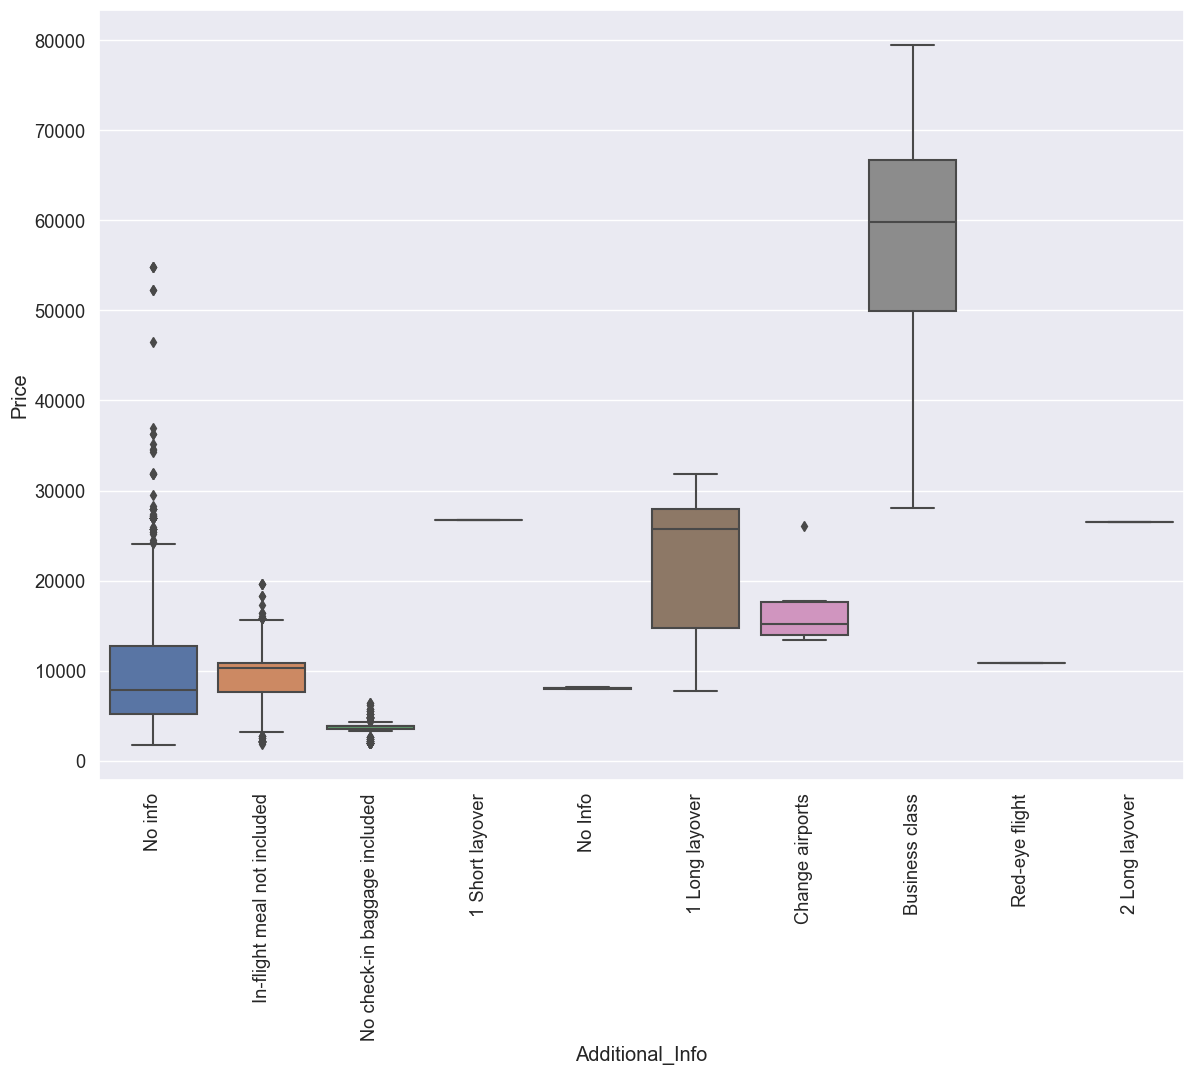

In [49]:
# What is the distribution of flight prices by additional info? Are there any outliers or extreme values?
plt.xticks(rotation=90)
sns.boxplot(data=df, x='Additional_Info', y='Price')

<Axes: xlabel='N_Route', ylabel='Price'>

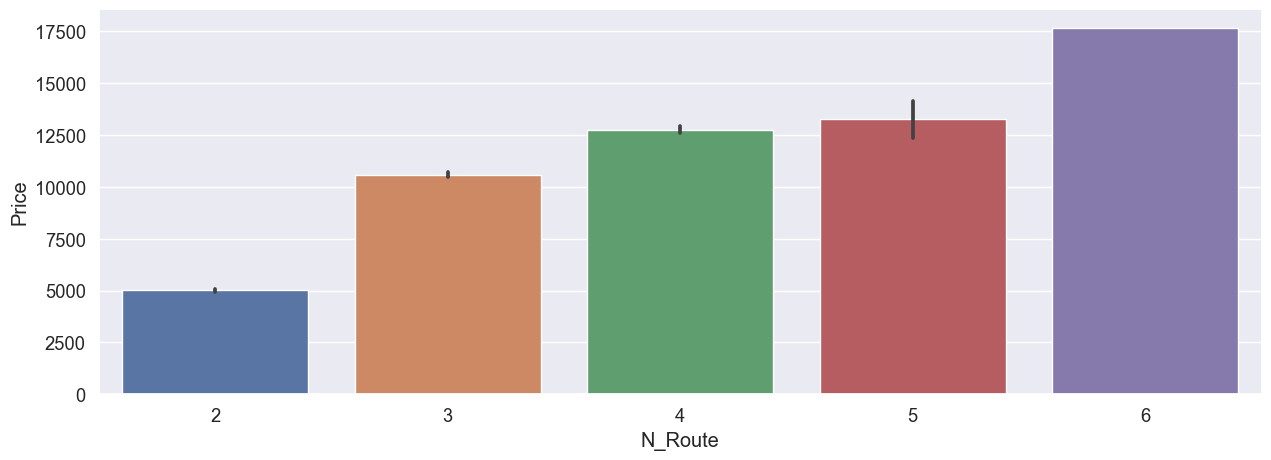

In [50]:
# Show the correlation between number of routes and price
plt.figure(figsize=(15, 5))
sns.barplot(x='N_Route', y='Price', data=df)

<Axes: xlabel='Season', ylabel='Price'>

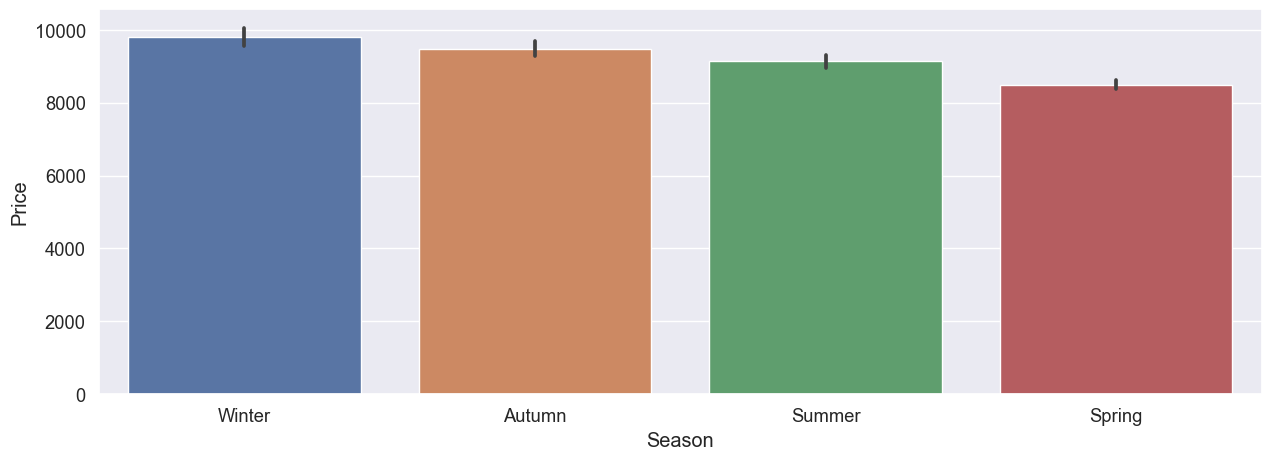

In [51]:
# Show in which season the price is higher
plt.figure(figsize=(15, 5))
sns.barplot(x='Season', y='Price', data=df, order=df.groupby('Season')['Price'].mean().sort_values(ascending=False).index)

<Axes: xlabel='Quarter', ylabel='Price'>

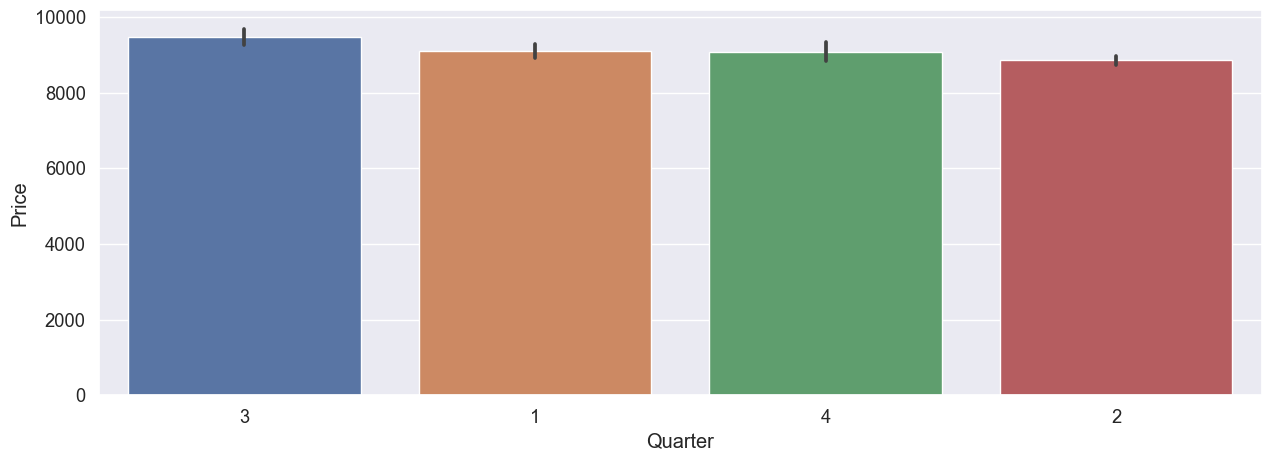

In [52]:
# Show in which quarter the price is higher
plt.figure(figsize=(15, 5))
sns.barplot(x='Quarter', y='Price', order=df.groupby('Quarter')['Price'].mean().sort_values(ascending=False).index, data=df)

<Axes: xlabel='Month', ylabel='Price'>

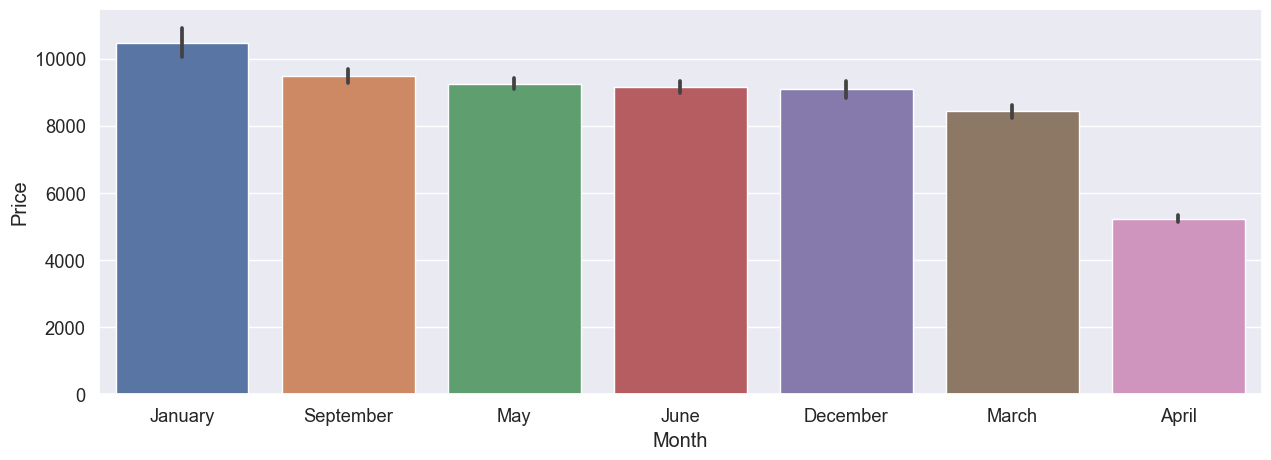

In [53]:
# Show in which month the price is higher
plt.figure(figsize=(15, 5))
sns.barplot(x='Month', y='Price', data=df, order=df.groupby('Month')['Price'].mean().sort_values(ascending=False).index)

<Axes: xlabel='Day_of_Week', ylabel='Price'>

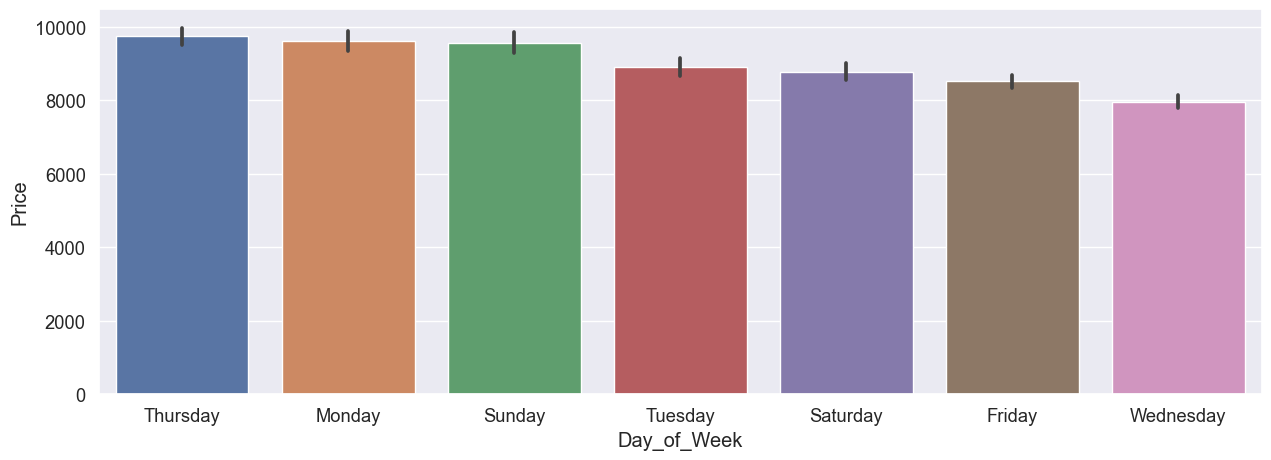

In [54]:
# Show in which day of the week the price is higher
plt.figure(figsize=(15, 5))
sns.barplot(x='Day_of_Week', y='Price', data=df, order=df.groupby('Day_of_Week')['Price'].mean().sort_values(ascending=False).index)

<Axes: xlabel='Airline', ylabel='Price'>

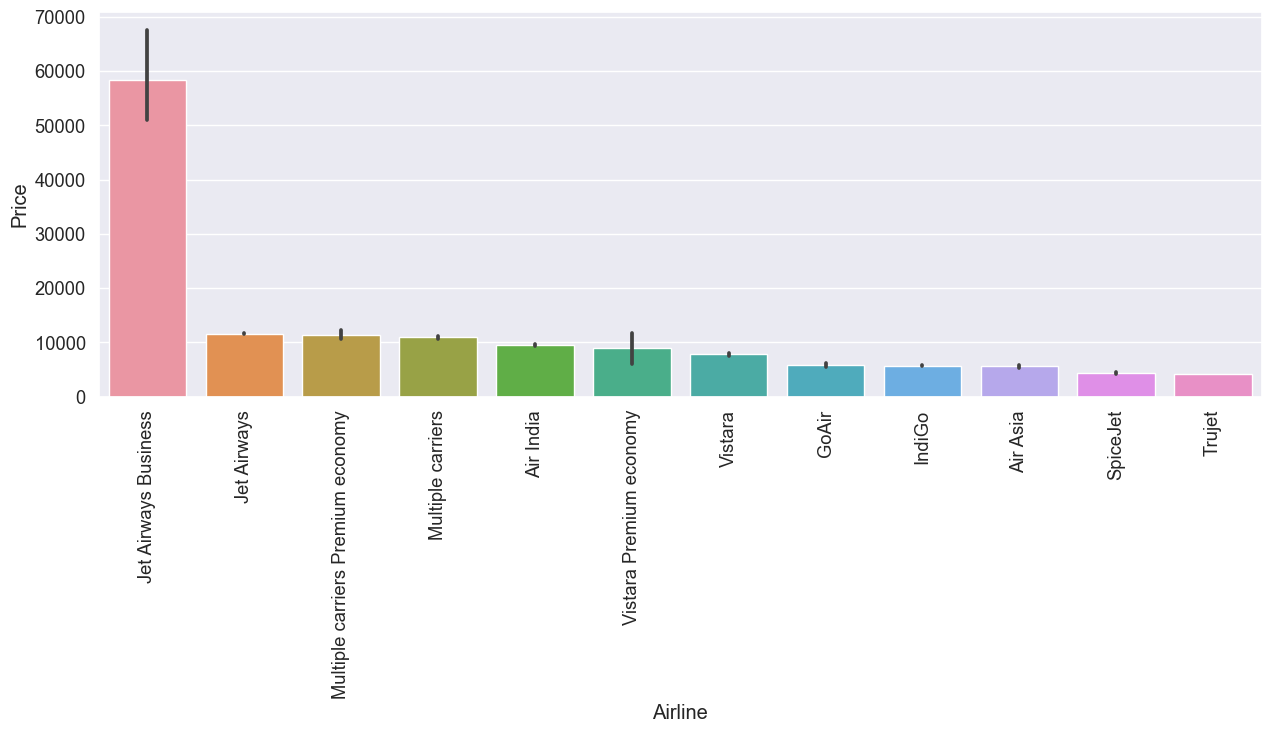

In [55]:
# How does the price of a flight vary by airline? Which airlines are generally more expensive or cheaper?
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='Airline', y='Price', data=df, order=df.groupby('Airline')['Price'].mean().sort_values(ascending=False).index)

<Axes: xlabel='Source', ylabel='Price'>

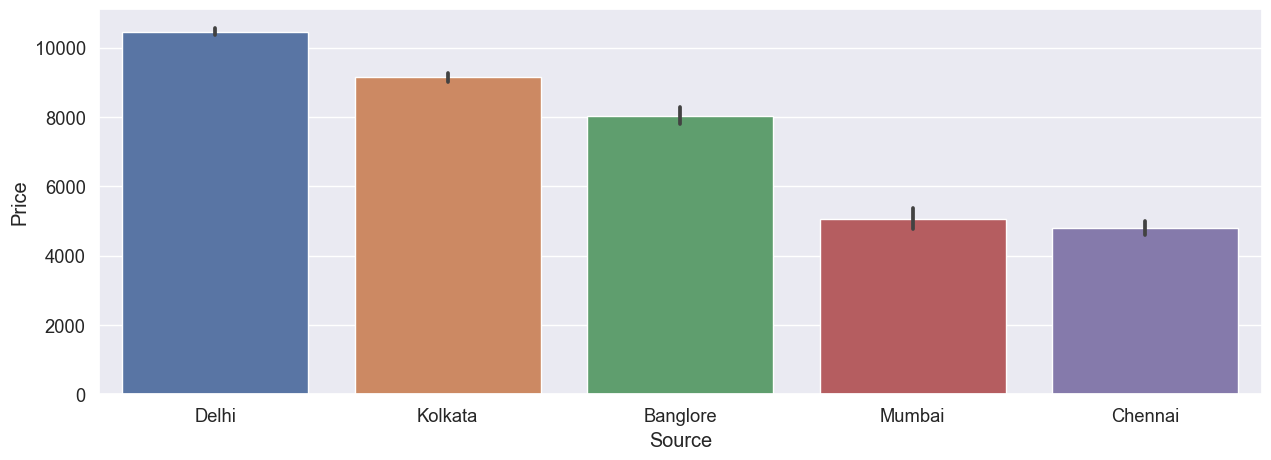

In [56]:
# How does the price of a flight vary by departure city? Are flights from certain cities generally more expensive or cheaper?
plt.figure(figsize=(15, 5))
sns.barplot(x='Source', y='Price', data=df, order=df.groupby('Source')['Price'].mean().sort_values(ascending=False).index)

<Axes: xlabel='Destination', ylabel='Price'>

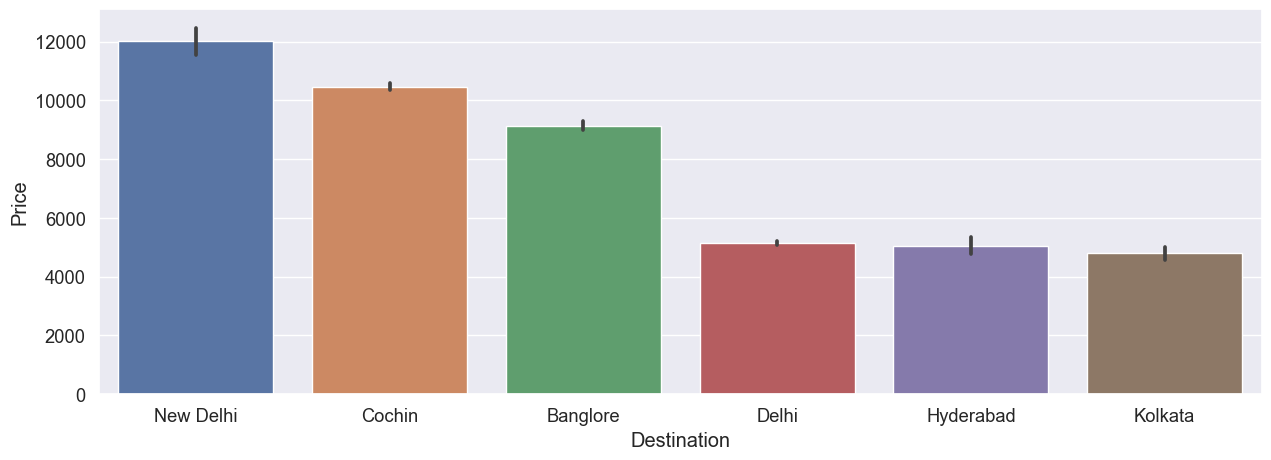

In [57]:
# How does the price of a flight vary by destination city? Are flights to certain cities generally more expensive or cheaper?
plt.figure(figsize=(15, 5))
sns.barplot(x='Destination', y='Price', data=df, order=df.groupby('Destination')['Price'].mean().sort_values(ascending=False).index)

<Axes: xlabel='Route_Status', ylabel='Price'>

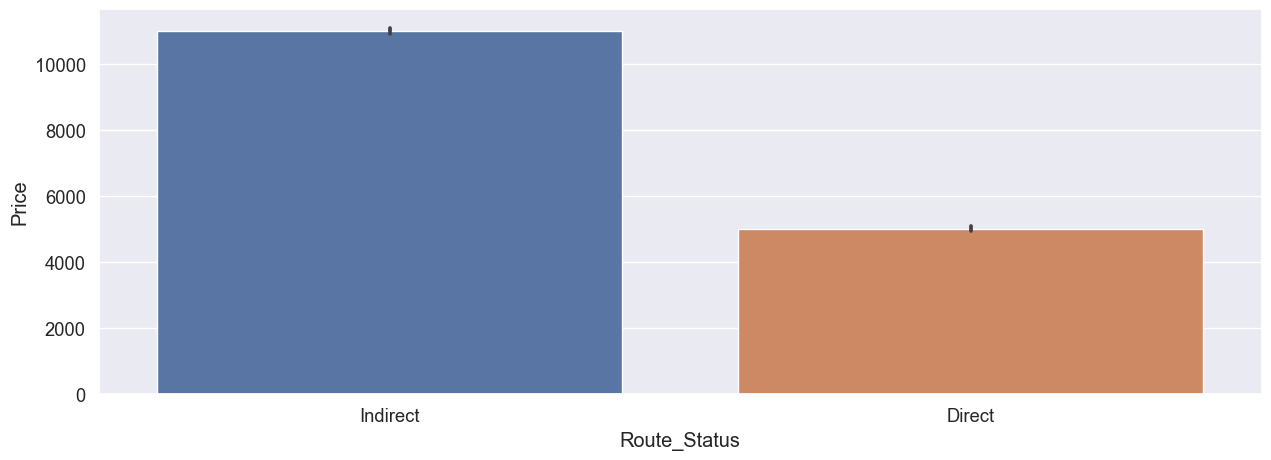

In [58]:
# How does the price of a flight vary by route status? Are flights with certain route statuses generally more expensive or cheaper?
plt.figure(figsize=(15, 5))
sns.barplot(x='Route_Status', y='Price', data=df, order=df.groupby('Route_Status')['Price'].mean().sort_values(ascending=False).index)

<Axes: xlabel='Duration', ylabel='Density'>

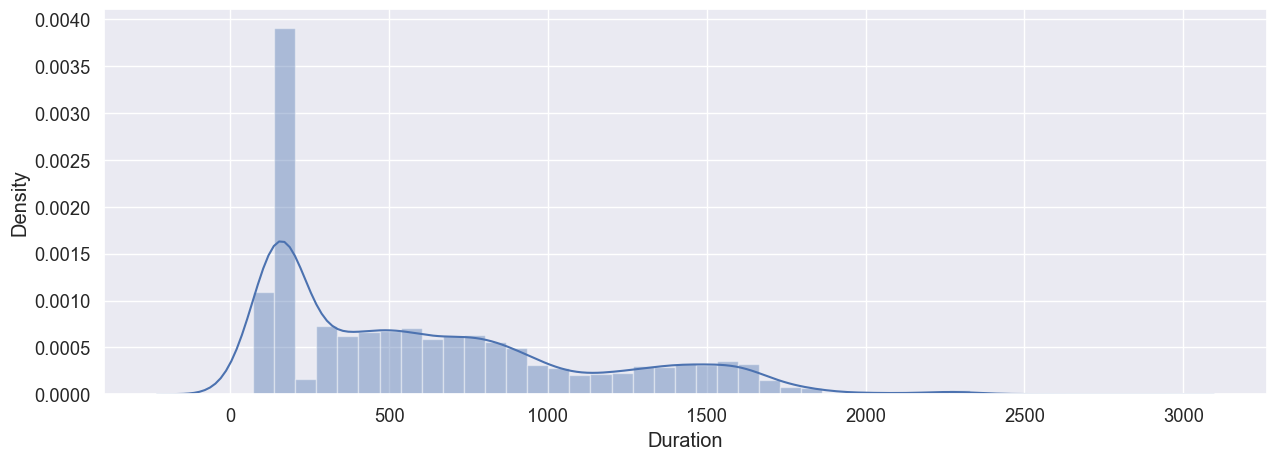

In [59]:
# Show the distribution of the duration
plt.figure(figsize=(15, 5))
sns.distplot(df['Duration'])

<Axes: xlabel='Duration', ylabel='Density'>

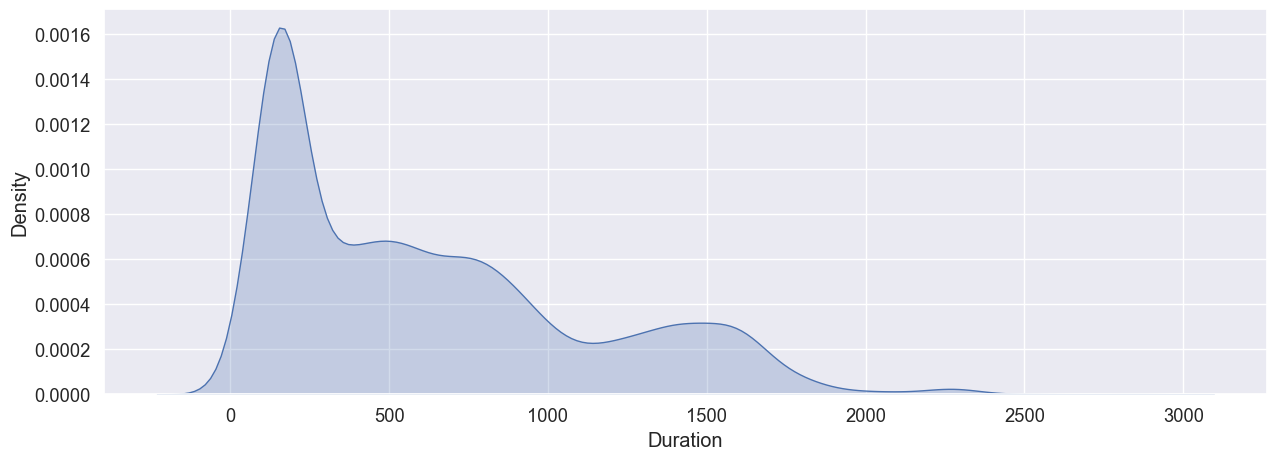

In [60]:
# Show the distribution of the duration
plt.figure(figsize=(15, 5))
sns.kdeplot(df['Duration'], shade=True)

<Axes: xlabel='Price', ylabel='Density'>

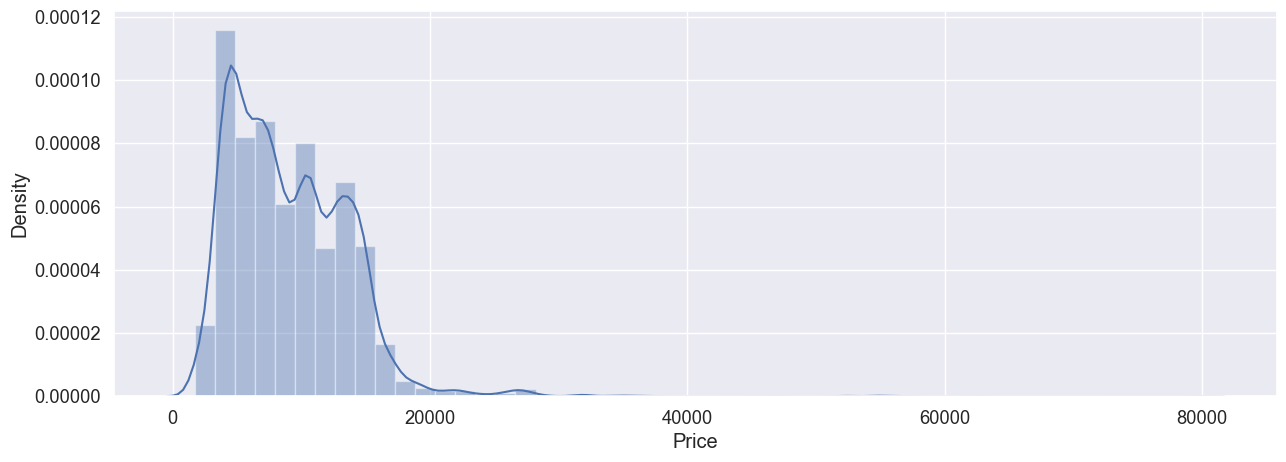

In [61]:
# Are the distributions of flight prices normally distributed? If not, what is the shape of the distribution?
plt.figure(figsize=(15, 5))
sns.distplot(df['Price'])

<Axes: xlabel='Price', ylabel='Density'>

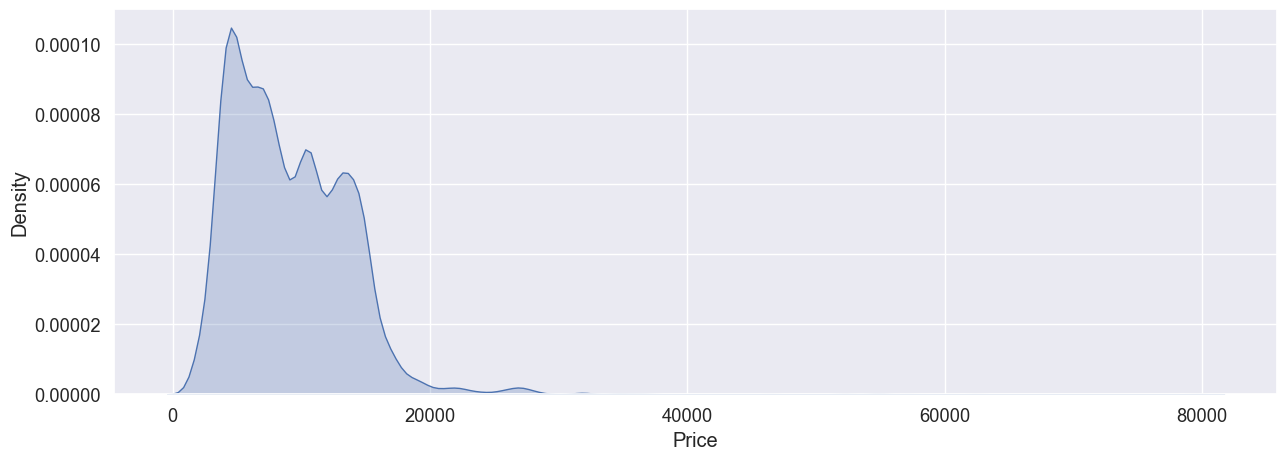

In [62]:
# Are the distributions of flight prices normally distributed? If not, what is the shape of the distribution?
plt.figure(figsize=(15, 5))
sns.kdeplot(df['Price'], shade=True)

<Axes: xlabel='Duration', ylabel='Density'>

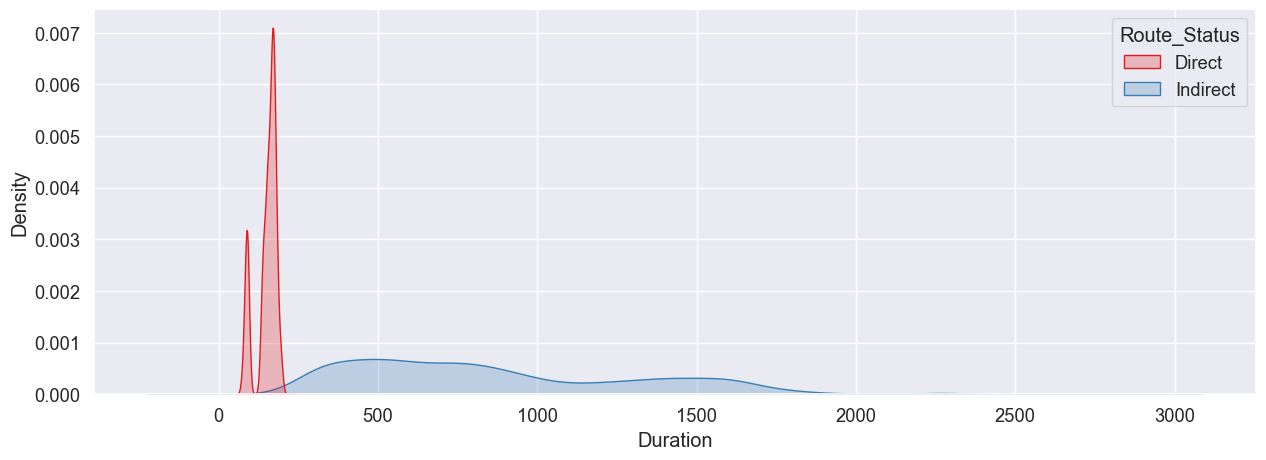

In [63]:
# Are the trip durations normally distributed for both direct and indirect flights? If not, what is the shape of the distribution?
plt.figure(figsize=(15, 5))
sns.kdeplot(data=df, x='Duration', hue='Route_Status', shade=True, palette='Set1')

<Axes: xlabel='Duration', ylabel='Density'>

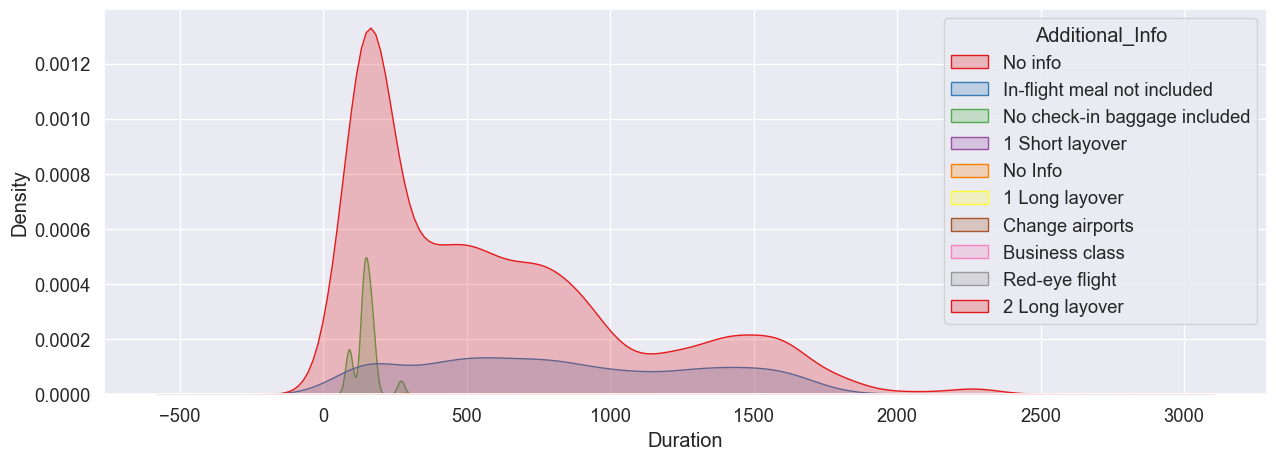

In [64]:
# Are the trip durations normally distributed for each unique value in additional info? If not, what is the shape of the distribution?
plt.figure(figsize=(15, 5))
sns.kdeplot(data=df, x='Duration', hue='Additional_Info', shade=True, palette='Set1')

<Axes: xlabel='Price', ylabel='Density'>

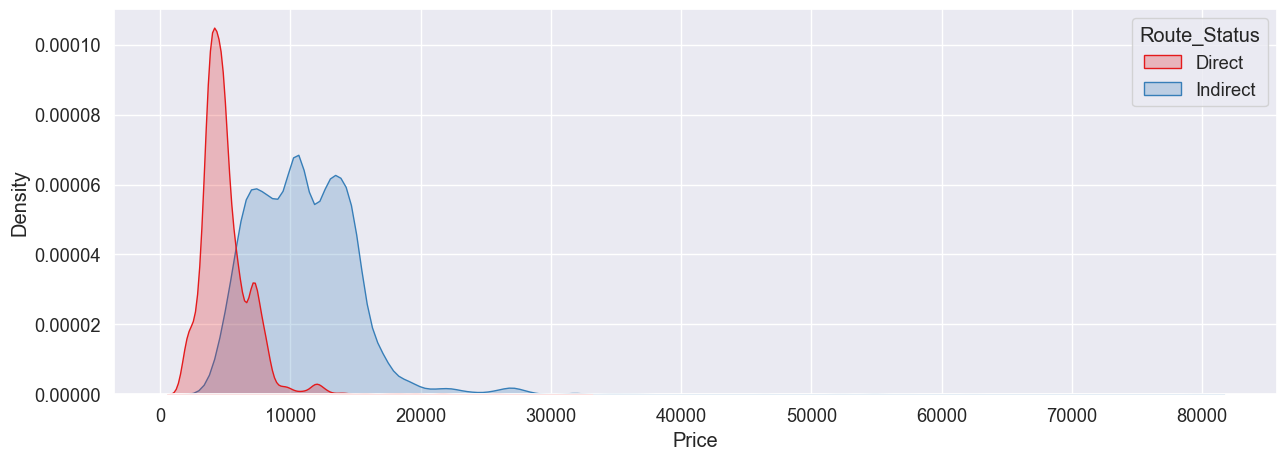

In [65]:
# Are the flight prices normally distributed for both direct and indirect flights? If not, what is the shape of the distribution?
plt.figure(figsize=(15, 5))
sns.kdeplot(data=df, x='Price', hue='Route_Status', shade=True, palette='Set1')

<Axes: xlabel='Price', ylabel='Density'>

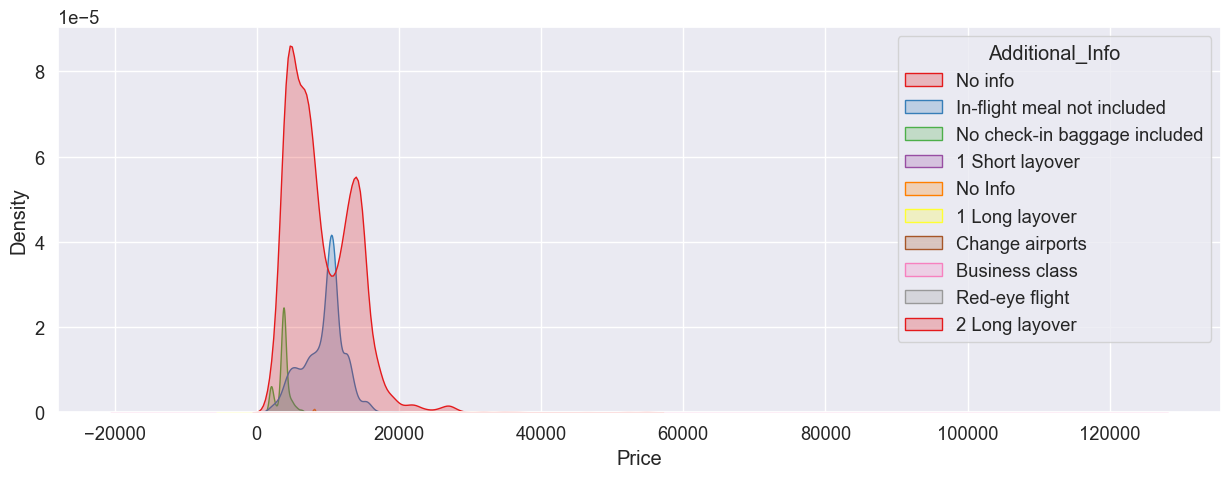

In [66]:
# Are the flight prices normally distributed for each unique value in additional info? If not, what is the shape of the distribution?
plt.figure(figsize=(15, 5))
sns.kdeplot(data=df, x='Price', hue='Additional_Info', shade=True, palette='Set1')

### Data Preprocessing:

- Handle values in `Airline`

In [67]:
df[df['Airline'] == 'Multiple carriers Premium economy']

,Airline,Date_of_Journey,Time_Period,Source,Destination,Duration,N_Route,Total_Stops,Route_Status,F_Route,L_Route,Year,Season,Quarter,Month,Day_of_Week,Additional_Info,Price
716,Multiple carriers Premium economy,2019-03-21,Morning,Delhi,Cochin,705,3,1,Indirect,DEL,COK,2019,Spring,1,March,Thursday,No info,10161
1792,Multiple carriers Premium economy,2019-03-21,Morning,Delhi,Cochin,810,3,1,Indirect,DEL,COK,2019,Spring,1,March,Thursday,No info,9845
4580,Multiple carriers Premium economy,2019-03-21,Morning,Delhi,Cochin,620,3,1,Indirect,DEL,COK,2019,Spring,1,March,Thursday,No info,10161
4668,Multiple carriers Premium economy,2019-03-21,Morning,Delhi,Cochin,900,3,1,Indirect,DEL,COK,2019,Spring,1,March,Thursday,No info,9845
5035,Multiple carriers Premium economy,2019-03-21,Morning,Delhi,Cochin,440,3,1,Indirect,DEL,COK,2019,Spring,1,March,Thursday,No info,11269
5425,Multiple carriers Premium economy,2019-03-21,Morning,Delhi,Cochin,570,3,1,Indirect,DEL,COK,2019,Spring,1,March,Thursday,No info,11269
5608,Multiple carriers Premium economy,2019-03-21,Morning,Delhi,Cochin,770,3,1,Indirect,DEL,COK,2019,Spring,1,March,Thursday,No info,14629
5771,Multiple carriers Premium economy,2019-03-21,Morning,Delhi,Cochin,680,3,1,Indirect,DEL,COK,2019,Spring,1,March,Thursday,No info,14629
6393,Multiple carriers Premium economy,2019-03-21,Morning,Delhi,Cochin,725,3,1,Indirect,DEL,COK,2019,Spring,1,March,Thursday,No info,9845
6512,Multiple carriers Premium economy,2019-03-21,Morning,Delhi,Cochin,395,3,1,Indirect,DEL,COK,2019,Spring,1,March,Thursday,No info,11269


In [68]:
df[df['Airline'] == 'Jet Airways Business']

,Airline,Date_of_Journey,Time_Period,Source,Destination,Duration,N_Route,Total_Stops,Route_Status,F_Route,L_Route,Year,Season,Quarter,Month,Day_of_Week,Additional_Info,Price
657,Jet Airways Business,2019-01-03,Night,Banglore,New Delhi,300,3,1,Indirect,BLR,DEL,2019,Winter,1,January,Thursday,No info,52229
2904,Jet Airways Business,2019-01-03,Night,Banglore,New Delhi,340,3,1,Indirect,BLR,DEL,2019,Winter,1,January,Thursday,Business class,79512
5312,Jet Airways Business,2019-01-03,Night,Banglore,New Delhi,400,3,1,Indirect,BLR,DEL,2019,Winter,1,January,Thursday,Business class,62427
7254,Jet Airways Business,2019-03-03,Evening,Delhi,Cochin,500,4,2,Indirect,DEL,COK,2019,Spring,1,March,Sunday,No info,46490
9537,Jet Airways Business,2019-06-03,Evening,Delhi,Cochin,500,4,2,Indirect,DEL,COK,2019,Summer,2,June,Monday,No info,52285
10159,Jet Airways Business,2019-01-03,Morning,Banglore,New Delhi,280,3,1,Indirect,BLR,DEL,2019,Winter,1,January,Thursday,Business class,57209


In [69]:
df[df['Airline'] == 'Vistara Premium economy']

,Airline,Date_of_Journey,Time_Period,Source,Destination,Duration,N_Route,Total_Stops,Route_Status,F_Route,L_Route,Year,Season,Quarter,Month,Day_of_Week,Additional_Info,Price
426,Vistara Premium economy,2019-03-03,Afternoon,Banglore,New Delhi,155,2,0,Direct,BLR,DEL,2019,Spring,1,March,Sunday,No info,11793
7555,Vistara Premium economy,2019-01-03,Morning,Chennai,Kolkata,135,2,0,Direct,MAA,CCU,2019,Winter,1,January,Thursday,No info,9125
8483,Vistara Premium economy,2019-06-04,Morning,Banglore,Delhi,170,2,0,Direct,BLR,DEL,2019,Summer,2,June,Tuesday,No info,5969


In [70]:
df[df['Airline'] == 'Trujet']

,Airline,Date_of_Journey,Time_Period,Source,Destination,Duration,N_Route,Total_Stops,Route_Status,F_Route,L_Route,Year,Season,Quarter,Month,Day_of_Week,Additional_Info,Price
2859,Trujet,2019-06-03,Afternoon,Mumbai,Hyderabad,195,3,1,Indirect,BOM,HYD,2019,Summer,2,June,Monday,No info,4140


In [71]:
# Define a function to return other airlines for the airlines with very few flights
def other_airlines(x):
    if x == 'Vistara Premium economy':
        return 'Other'
    elif x == 'Trujet':
        return 'Other'
    else:
        return x

# Apply the function
df['Airline'] = df['Airline'].apply(other_airlines)

- `Time_Period`, `Route_Status`, `Season` should be converted to numerical

In [72]:
# Use map to convert Time_Period to numerical values
df['Time_Period'] = df['Time_Period'].map({'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}).astype('int64')

# Use map to convert Route_Status to numerical values
df['Route_Status'] = df['Route_Status'].map({'Direct': 0, 'Indirect': 1}).astype('int64')

# Use map to convert Season to numerical values
df['Season'] = df['Season'].map({'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}).astype('int64')

### Feature Selection:

- Get correlations between the features

In [73]:
features = df[['Time_Period', 'Duration', 'N_Route', 'Total_Stops', 'Route_Status', 'Season', 'Quarter', 'Price']]

<Axes: >

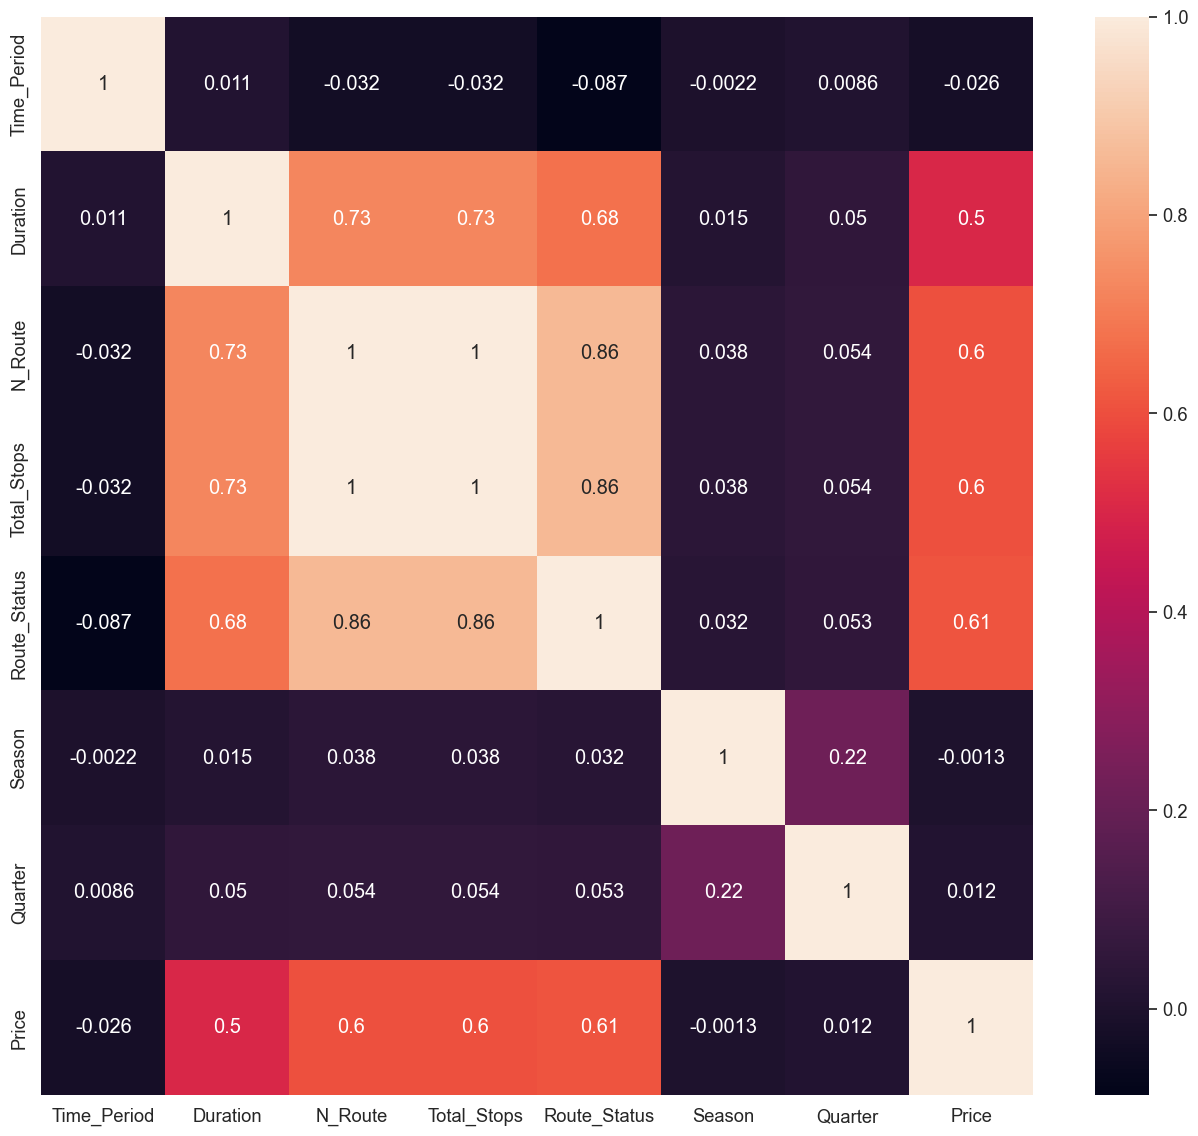

In [74]:
corr = features.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr, annot=True)

- Drop `Date_of_Journey`, `F_Route`, `L_Route`, `Year`, `Season`, `Quarter`, `Month`, `Day_of_Week`, `N_Route`

In [75]:
df.drop(['Date_of_Journey', 'F_Route', 'L_Route', 'Year', 'Season', 'Quarter', 'Month', 'Day_of_Week', 'N_Route'], axis=1, inplace=True)

- Convert `Time_Period`, `Route_Status` to categorical

In [76]:
# Use map to convert Time_Period to categorical values
df['Time_Period'] = df['Time_Period'].map({0: 'Morning', 1: 'Afternoon', 2: 'Evening', 3: 'Night'})

# Use map to convert Route_Status to categorical values
df['Route_Status'] = df['Route_Status'].map({0: 'Direct', 1: 'Indirect'})

- Display data details and types

In [77]:
df.head()

,Airline,Time_Period,Source,Destination,Duration,Total_Stops,Route_Status,Additional_Info,Price
0,IndiGo,Evening,Banglore,New Delhi,170,0,Direct,No info,3897
1,Air India,Night,Kolkata,Banglore,445,2,Indirect,No info,7662
2,Jet Airways,Morning,Delhi,Cochin,1140,2,Indirect,No info,13882
3,IndiGo,Evening,Kolkata,Banglore,325,1,Indirect,No info,6218
4,IndiGo,Afternoon,Banglore,New Delhi,285,1,Indirect,No info,13302


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10462 entries, 0 to 10461
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10462 non-null  object
 1   Time_Period      10462 non-null  object
 2   Source           10462 non-null  object
 3   Destination      10462 non-null  object
 4   Duration         10462 non-null  int64 
 5   Total_Stops      10462 non-null  int64 
 6   Route_Status     10462 non-null  object
 7   Additional_Info  10462 non-null  object
 8   Price            10462 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 735.7+ KB


In [79]:
for col in df.columns:
    print(f'Unique values for ({col}): {len(df[col].unique())}')

Unique values for (Airline): 11
Unique values for (Time_Period): 4
Unique values for (Source): 5
Unique values for (Destination): 6
Unique values for (Duration): 368
Unique values for (Total_Stops): 5
Unique values for (Route_Status): 2
Unique values for (Additional_Info): 10
Unique values for (Price): 1870


In [80]:
df.describe()

,Duration,Total_Stops,Price
count,10462.000000,10462.000000,10462.000000
mean,629.781591,0.802332,9026.790289
std,500.699045,0.660609,4624.849541
min,5.000000,0.000000,1759.000000
25%,170.000000,0.000000,5224.000000
50%,505.000000,1.000000,8266.000000
75%,910.000000,1.000000,12344.750000
max,2860.000000,4.000000,79512.000000


### Machine Learning Models:

- Model Selection (using pipeline)

In [81]:
# Split the data into features and target
x = df.drop('Price', axis=1)
y = df['Price']

- Transformers

In [82]:
Encoder = ColumnTransformer(transformers=[('OHE', OneHotEncoder(sparse=False, drop='first'), ['Time_Period', 'Source', 'Destination', 'Route_Status']), ('BE', BinaryEncoder(), ['Airline', 'Additional_Info'])], remainder='passthrough')

In [83]:
#Power = ColumnTransformer(transformers=[('Power', PowerTransformer(), ['Duration'])], remainder='passthrough')

In [84]:
#Standardize = ColumnTransformer(transformers=[('Scaler', RobustScaler(), ['Duration'])], remainder='passthrough')

- Models

In [85]:
# Define the models
models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('KNeighbors', KNeighborsRegressor()))
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('Bagging', BaggingRegressor()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('XGBoost', XGBRegressor()))
models.append(('LightGBM', LGBMRegressor()))
models.append(('CatBoost', CatBoostRegressor()))

In [86]:
# Show the models score
for name, model in models:
    
    steps = []
    steps.append(('Encoder', Encoder))
    steps.append(('Power', PowerTransformer()))
    steps.append(('Standardize', RobustScaler()))
    steps.append(('Model', model))
    pipeline = Pipeline(steps=steps)
    
    results = cross_validate(pipeline, x, y, cv=10, scoring='r2', return_train_score=True, error_score='raise', n_jobs=-1)
    train_r2_score = results['train_score'].mean()
    test_r2_score = results['test_score'].mean()

    print(" ".join(["For", name, "Algorithm..."]))
    print("Best train score is %f" % train_r2_score, "Best test score is %f" % test_r2_score, sep="\n")
    print()

For LinearRegression Algorithm...
Best train score is 0.582873
Best test score is 0.582281

For KNeighbors Algorithm...
Best train score is 0.784923
Best test score is 0.718838

For DecisionTree Algorithm...
Best train score is 0.857151
Best test score is 0.661282

For Bagging Algorithm...
Best train score is 0.841196
Best test score is 0.703736

For RandomForest Algorithm...
Best train score is 0.847345
Best test score is 0.716115

For XGBoost Algorithm...
Best train score is 0.832928
Best test score is 0.741311

For LightGBM Algorithm...
Best train score is 0.764404
Best test score is 0.711064

For CatBoost Algorithm...
Best train score is 0.806464
Best test score is 0.751059



- `CatBoostRegressor` (hyperparameter tuning)

In [87]:
params = {
    'CatBoost__random_state': [95],
    'CatBoost__iterations': [95],
    'CatBoost__max_depth': [6],
    'CatBoost__learning_rate': [0.4],
    'CatBoost__silent': [True]
}

In [88]:
steps = []
steps.append(('Encoder', Encoder))
steps.append(('Power', PowerTransformer()))
steps.append(('Standardize', RobustScaler()))
steps.append(('CatBoost', CatBoostRegressor()))
pipeline = Pipeline(steps=steps)

In [89]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, scoring='r2', return_train_score=True, n_jobs=-1)

In [90]:
grid_search.fit(x, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('OHE',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['Time_Period',
                                                                          'Source',
                                                                          'Destination',
                                                                          'Route_Status']),
                                                                        ('BE',
                                                                         BinaryEncoder(),
                                                                         ['Airline',
                                                                          'Additional_Info'])])),
                                       ('Power', PowerTransformer()),
                                       ('Standardize', RobustScaler()),
                                       ('CatBoost',
                                        <catboost.core.CatBoostRegressor object at 0x000002244894E020>)]),
             n_jobs=-1,
             param_grid={'CatBoost__iterations': [95],
                         'CatBoost__learning_rate': [0.4],
                         'CatBoost__max_depth': [6],
                         'CatBoost__random_state': [95],
                         'CatBoost__silent': [True]},
             return_train_score=True, scoring='r2')

In [91]:
print(f"Train: {grid_search.cv_results_['mean_train_score'].mean()}, Test: {grid_search.cv_results_['mean_test_score'].mean()}")

Train: 0.7957032948247267, Test: 0.7492932783996717


In [92]:
final_model = grid_search.best_estimator_

### Deployment:

- Create new data row for prediction

In [93]:
for s, p in zip((grid_search.cv_results_['mean_test_score']), (grid_search.cv_results_['params'])):
    print(f'Mean Test Score: {s}, Parameters: {p}')

Mean Test Score: 0.7492932783996717, Parameters: {'CatBoost__iterations': 95, 'CatBoost__learning_rate': 0.4, 'CatBoost__max_depth': 6, 'CatBoost__random_state': 95, 'CatBoost__silent': True}


In [94]:
GS_Results = pd.DataFrame(grid_search.cv_results_['rank_test_score'], columns=['Rank'])
GS_Results['Mean Test Score'] = grid_search.cv_results_['mean_test_score']
GS_Results['Learning Rate'] = grid_search.cv_results_['params'][0]['CatBoost__learning_rate']
GS_Results['Max Depth'] = grid_search.cv_results_['params'][0]['CatBoost__max_depth']
GS_Results['Iterations'] = grid_search.cv_results_['params'][0]['CatBoost__iterations']
GS_Results['Random State'] = grid_search.cv_results_['params'][0]['CatBoost__random_state']
GS_Results

,Rank,Mean Test Score,Learning Rate,Max Depth,Iterations,Random State
0,1,0.749293,0.4,6,95,95


In [95]:
GS_Results = GS_Results.sort_values(by=['Rank'])
GS_Results

,Rank,Mean Test Score,Learning Rate,Max Depth,Iterations,Random State
0,1,0.749293,0.4,6,95,95


In [96]:
GS_Results[GS_Results['Mean Test Score'] == GS_Results['Mean Test Score'].max()]

,Rank,Mean Test Score,Learning Rate,Max Depth,Iterations,Random State
0,1,0.749293,0.4,6,95,95


In [97]:
# features dataframe
x

,Airline,Time_Period,Source,Destination,Duration,Total_Stops,Route_Status,Additional_Info
0,IndiGo,Evening,Banglore,New Delhi,170,0,Direct,No info
1,Air India,Night,Kolkata,Banglore,445,2,Indirect,No info
2,Jet Airways,Morning,Delhi,Cochin,1140,2,Indirect,No info
3,IndiGo,Evening,Kolkata,Banglore,325,1,Indirect,No info
4,IndiGo,Afternoon,Banglore,New Delhi,285,1,Indirect,No info
...,...,...,...,...,...,...,...,...
10457,Air Asia,Evening,Kolkata,Banglore,150,0,Direct,No info
10458,Air India,Evening,Kolkata,Banglore,155,0,Direct,No info
10459,Jet Airways,Morning,Banglore,Delhi,180,0,Direct,No info
10460,Vistara,Morning,Banglore,New Delhi,160,0,Direct,No info


In [98]:
# Inputs needed for prediction
x.columns

Index(['Airline', 'Time_Period', 'Source', 'Destination', 'Duration',
       'Total_Stops', 'Route_Status', 'Additional_Info'],
      dtype='object')

In [99]:
# Create virtual inputs to form a new data row to use it in testing the model
airline = input('Enter Airline: ')
time_period = input('Enter Time Period: ')
source = input('Enter Source: ')
destination = input('Enter Destination: ')
duration = int(input('Enter Duration: '))
total_stops = int(input('Enter Total Stops: '))
route_status = input('Enter Route Status: ')
additional_info = input('Enter Additional Info: ')

# Create a list of inputs
row_data = [airline, time_period, source, destination, duration, total_stops, route_status, additional_info]

# Print the list values
print(row_data)

['IndiGo', 'Evening', 'Banglore', 'New Delhi', 170, 0, 'Direct', 'No info']


In [100]:
# Convert row_data to a DataFrame
df_test = pd.DataFrame([row_data], columns=x.columns)

In [101]:
# Predict the price using the final_model
final_model.predict(df_test)

array([7283.91554784])

In [102]:
# Save the model and inputs
joblib.dump(final_model, "model.h5")
joblib.dump(x.columns, "inputs.h5")

['inputs.h5']

In [103]:
# Load the model
mo = joblib.load("model.h5")

In [104]:
# Predict the price of a flight
mo.predict(df_test)

array([7283.91554784])